In [1]:
import numpy as np
from scipy import ndimage
from scipy import spatial
from scipy import io
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from matplotlib import pyplot as plt
import seaborn as sns
from skimage import data
from skimage import color
from skimage import img_as_float

import graph3d

%matplotlib inline

# Load data

In [2]:
image = img_as_float(data.camera()[::2, ::2])

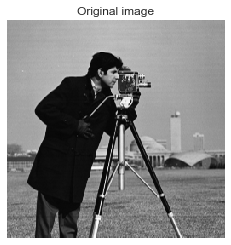

In [3]:
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
plt.grid('off')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])
ax.set_title('Original image')
plt.savefig('../img/tikhonov_regularization_0.pdf', bbox_inches='tight')

# Crop and add noise

In [4]:
image = image[40:80, 100:140]
noisy_image = image + 0.05*np.random.randn(*image.shape)

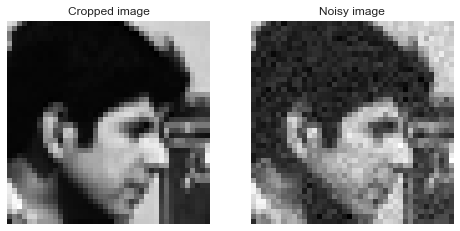

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(image, cmap='gray')
ax[1].imshow(noisy_image, cmap='gray')
ax[0].grid('off')
ax[1].grid('off')
ax[0].xaxis.set_ticks([])
ax[0].yaxis.set_ticks([])
ax[1].xaxis.set_ticks([])
ax[1].yaxis.set_ticks([])
ax[0].set_title('Cropped image')
ax[1].set_title('Noisy image')
plt.savefig('../img/tikhonov_regularization_1.pdf', bbox_inches='tight')

# Perform graph filtering

#### Given a signal $f_0$ corrupted by Gaussian noise $\eta$

\begin{equation}
    \mathbf{y} = \mathbf{f_0} + \mathbf{\eta}
\end{equation}

#### Solve the regularization problem

\begin{equation}
    \underset{f}{\text{argmin}} \{ ||f - y||_2^2 + \gamma f^T L f\}
\end{equation}

#### Solution is given by

\begin{equation}
    f_{*}(i) = \sum_{l=0}^{N-1} \bigg[ \frac{1}{1 + \gamma \lambda_l} \bigg] \hat{y}
(\lambda_l) u_l(i)
\end{equation}

#### Or equivalently

\begin{equation}
    \mathbf{f} = \hat{h}(L) \mathbf{y}
\end{equation}

#### Where L is the laplacian of the adjacency matrix defined by:

\begin{equation}
    W_{i,j} = 
    \begin{cases}
    \exp \bigg( - \frac{[dist(i, j)]^2}{2 \theta^2} \bigg) & \text{if $dist(i,j)$ < $\kappa$} \\
    0 & \text{otherwise}
    \end{cases}
\end{equation}


In [6]:
# Parameters
kappa = np.sqrt(2)
theta = 20
gamma = 10

In [7]:
# Query neighboring pixels for each pixel
yx = np.vstack(np.dstack(np.indices(noisy_image.shape)))
tree = spatial.cKDTree(yx)
q = tree.query_ball_point(yx, kappa)

# Get pixels I, and neighbors J
I = np.concatenate([np.repeat(k, len(q[k])) for k in range(len(q))])
J = np.concatenate(q)

# Distance metric is difference between neighboring pixels
dist_ij = np.sqrt(((noisy_image.flat[I] - noisy_image.flat[J])**2))

# Thresholded Gaussian kernel weighting function
W = np.exp(- ((dist_ij)**2 / 2*(theta**2)) )

In [8]:
# Construct sparse adjacency matrix
A = sparse.lil_matrix((noisy_image.size, noisy_image.size))

for i, j, w in zip(I, J, W):
    A[i, j] = w
    A[j, i] = w
    
A = A.todense()

In [9]:
# Compute Laplacian
L = csgraph.laplacian(A)

# Compute eigenvalues and eigenvectors of laplacian
l, u = linalg.eigh(L)

# Compute filtering kernel
h = u @ np.diag(1 / (1 + gamma*l)) @ u.T

# Filter the image using the kernel
graph_filtered_image = (h @ noisy_image.ravel()).reshape(noisy_image.shape)

In [10]:
# Filter the image using traditional gaussian filtering
traditional_filtered_image = ndimage.gaussian_filter(noisy_image, 0.8)

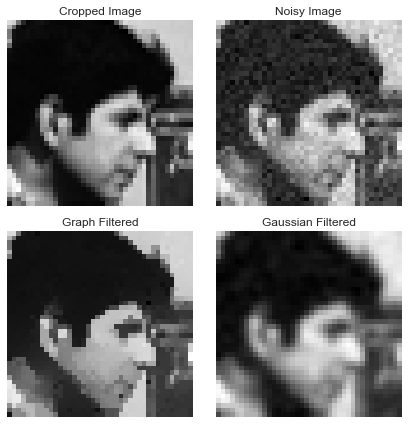

In [11]:
# Plot the result
fig, ax = plt.subplots(2, 2, figsize=(6, 6))

ax.flat[0].imshow(image, cmap='gray')
ax.flat[1].imshow(noisy_image, cmap='gray')
ax.flat[2].imshow(graph_filtered_image, cmap='gray')
ax.flat[3].imshow(traditional_filtered_image, cmap='gray')
ax.flat[0].grid('off')
ax.flat[1].grid('off')
ax.flat[2].grid('off')
ax.flat[3].grid('off')
ax.flat[0].xaxis.set_ticks([])
ax.flat[0].yaxis.set_ticks([])
ax.flat[1].xaxis.set_ticks([])
ax.flat[1].yaxis.set_ticks([])
ax.flat[2].xaxis.set_ticks([])
ax.flat[2].yaxis.set_ticks([])
ax.flat[3].xaxis.set_ticks([])
ax.flat[3].yaxis.set_ticks([])
ax.flat[0].set_title('Cropped Image')
ax.flat[1].set_title('Noisy Image')
ax.flat[2].set_title('Graph Filtered')
ax.flat[3].set_title('Gaussian Filtered')
plt.tight_layout()
plt.savefig('../img/tikhonov_regularization_2.pdf', bbox_inches='tight')